# Data analysis and plots for Figure 2

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import Pauli

from cut_graph import CutGraph
from stabilizer_plotter import StabilizerPlotter
from compute_witness import compute_witness

In [2]:
# Load the stabilizers that make-up the plot.
with open("data/figure2_data.json", "r") as fin:
    data = json.load(fin)

In [3]:
cgs = CutGraph("103_node_graph.json")
_ = cgs.edge_stabilizers()  # will generate labels

In [4]:
zne_factors = [float(c) for c in sorted(data["locc"].keys())]
zne_stabilizers_locc = {}

for stabilizer in data["locc"]["1.0"]:
    values = [data["locc"][str(c)][stabilizer][0] for c in zne_factors]
    sigmas = [data["locc"][str(c)][stabilizer][1] for c in zne_factors]
    fit_res = np.polyfit(zne_factors, values, deg=1, cov=True, w=[1/sig for sig in sigmas])

    zne_stabilizers_locc[stabilizer] = (fit_res[0][1], np.sqrt(fit_res[1][1][1]))

Generate the Figure 5(c) found in the appendix.

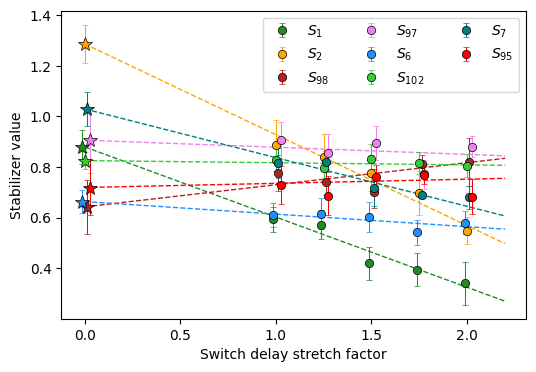

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

colors = ["forestgreen", "orange", "firebrick", "violet", "dodgerblue", "limegreen", "teal", "red"]

for idx, node in enumerate(cgs.nodes_on_cut):
    pauli = cgs.stabilizers([node])[0]
    stabs = [data["locc"][str(c)][pauli.to_label()][0] for c in zne_factors]
    sigmas = [data["locc"][str(c)][pauli.to_label()][1] for c in zne_factors]
    fit_res = np.polyfit(zne_factors, stabs, deg=1, cov=True, w=[1/sig for sig in sigmas])
    popt = fit_res[0]
    ax.plot([0, 1.1 * max(zne_factors)], [popt[1], popt[1] + popt[0] * 1.1 * max(zne_factors)], "--", lw=1, color=colors[idx])
    ax.errorbar(
        np.array(zne_factors) + (idx % 4) / 80 - 1/80,
        stabs,
        fmt="o",
        color=colors[idx],
        label=cgs.stabilizer_label(pauli),
        yerr=sigmas,
        capsize=2,
        ecolor=colors[idx],
        elinewidth=0.75,
        markeredgecolor="k",
        markeredgewidth=0.5,
    )
    ax.errorbar(
        [0 + (idx % 4) / 80 - 1/80],
        [zne_stabilizers_locc[pauli.to_label()][0]],
        fmt="*",
        yerr=[zne_stabilizers_locc[pauli.to_label()][1]],
        color=colors[idx],
        capsize=2,
        elinewidth=0.75,
        markersize=10,
        markeredgecolor="k",
        markeredgewidth=0.5,
        ecolor=colors[idx],
    )

ax.legend(ncol=3)
ax.set_xlabel("Switch delay stretch factor")
ax.set_ylabel("Stabilizer value");

## Plot the stabilizers and the edge witnesses

In [6]:
witnesses, witnesses_zne = {}, {}

for tag in data:
    witnesses[tag] = compute_witness(data[tag]["1.0"], cgs.graph, cgs)

# Compute LOCC witnesses by taking ZNE only for those affected by the cut.
witnesses_zne["locc"] = compute_witness(zne_stabilizers_locc, cgs.graph, cgs, stabilizers_zne=zne_stabilizers_locc)

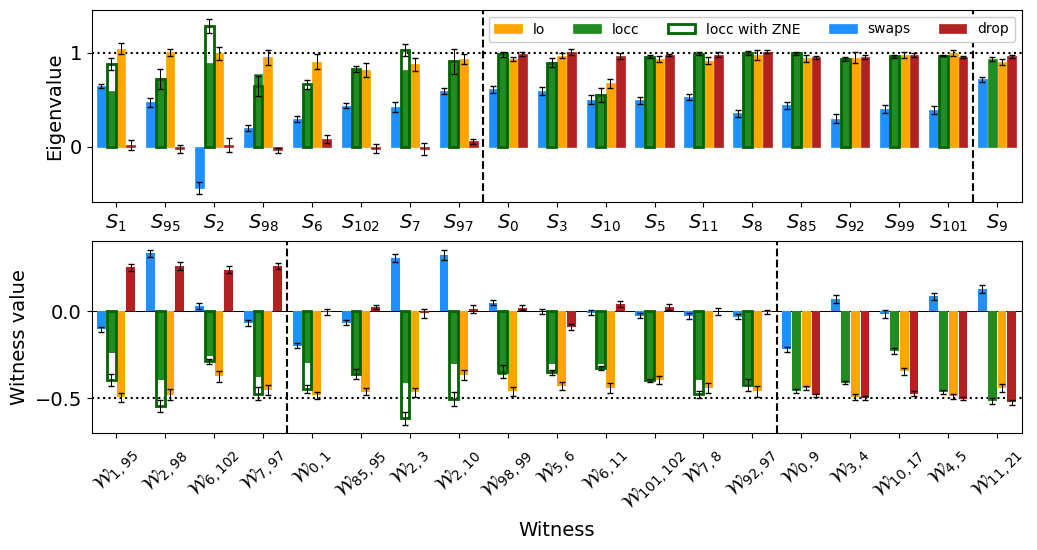

In [7]:
plt.rcParams["font.size"] = 14

fig, ax = StabilizerPlotter(cgs).stabilizer_witness_plot(data, zne_stabilizers_locc, witnesses, witnesses_zne)

## Plot the cumulative distribution function

For LOCC, use stabilizer values obtained from ZNE for stabilizers affected by the cut.

In [8]:
stabilizer_vals_locc = {"1.0": {}}

for stab, value in data["locc"]["1.0"].items():
    if cgs.touches_cut(Pauli(stab)):
        stabilizer_vals_locc["1.0"][stab] = zne_stabilizers_locc[stab]
    else:
        stabilizer_vals_locc["1.0"][stab] = value

Find the errors of the node stabilizers that are on a cut.

In [9]:
errors_to_flag_locc, errors_to_flag_drop, errors_to_flag_lo, errors_to_flag_swap = [], [], [], []

for node in cgs.nodes_on_cut:
    stab = cgs.stabilizers([node])[0].to_label()
    errors_to_flag_locc.append(abs(stabilizer_vals_locc["1.0"][stab][0]-1))
    errors_to_flag_drop.append(abs(data["drop"]["1.0"][stab][0]-1))
    errors_to_flag_lo.append(abs(data["lo"]["1.0"][stab][0]-1))
    errors_to_flag_swap.append(abs(data["swaps"]["1.0"][stab][0]-1))

Plot the CDF of the stabilizer errors.

In [10]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

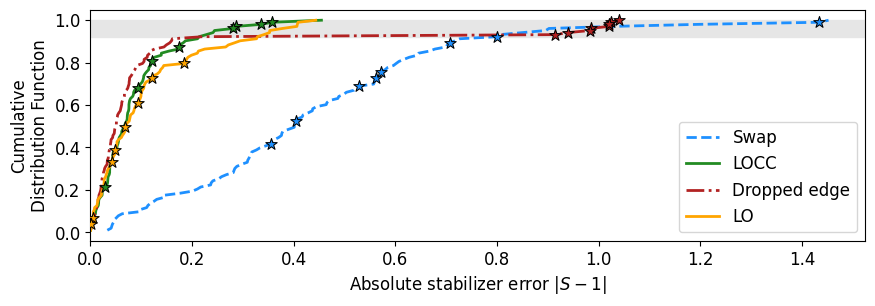

In [11]:
plt.rcParams["font.size"]= 12
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
lines = []

# Compute the stabilizer error, i.e., |S-1|. A node stabilizer has a single X in its Pauli
se_swap = [abs(x[0]-1) for p, x in data["swaps"]["1.0"].items() if sum(Pauli(p).x) == 1]
se_drop = [abs(x[0]-1) for p, x in data["drop"]["1.0"].items() if sum(Pauli(p).x) == 1]
se_lo   = [abs(x[0]-1) for p, x in data["lo"]["1.0"].items() if sum(Pauli(p).x) == 1]
se_locc = [abs(x[0]-1) for p, x in stabilizer_vals_locc["1.0"].items() if sum(Pauli(p).x) == 1]

cases = [
    (se_swap, "Swap", "dodgerblue", "--", errors_to_flag_swap), 
    (se_locc, "LOCC", "forestgreen", "-", errors_to_flag_locc), 
    (se_drop, "Dropped edge", "firebrick", "-.", errors_to_flag_drop), 
    (se_lo, "LO", "orange", "-", errors_to_flag_lo)
]

ax.xaxis.tick_top()
for errs, lbl, color, ls, cut_errs in cases:
    n = np.arange(1, len(errs)+1) / float(len(errs))

    # add points for the nodes that are on the cuts
    x, y = ecdf(errs)
    errs = np.sort(errs).tolist()
    ax.plot(x, y, color=color, label=lbl, lw=2, ls=ls)
    
    indices = [errs.index(err) for err in cut_errs]
    ax.scatter(cut_errs, [y[idx] for idx in indices], s=75, color=color, zorder=10, ec="k", marker="*", lw=0.75)
    lines.append((x, y, lbl, color, ls, cut_errs, [y[idx] for idx in indices]))

xlims = ax.get_xlim()
ax.fill_between(xlims, [1-len(errors_to_flag_drop)/len(se_drop)]*2, [1]*2, color=[0.9]*3)
ax.set_xlim([0, xlims[1]])
ax.set_ylabel("Cumulative\nDistribution Function")
ax.legend()
ax.xaxis.tick_bottom()
ax.set_xlabel("Absolute stabilizer error $|S-1|$");

Plot the same data but in a different format.

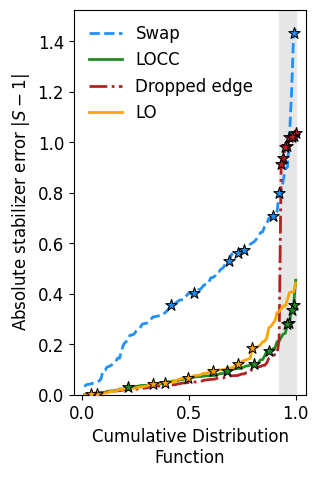

In [12]:
plt.rcParams["font.size"]= 12
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

for x, y, lbl, color, ls, cut_errs, cut_errs_y in lines:
    plt.plot(y, x, label=lbl, ls=ls, color=color, lw=2)
    ax.scatter(cut_errs_y, cut_errs, s=75, color=color, zorder=10, ec="k", marker="*", lw=0.75)

ax.legend(frameon=False)
ylims = ax.get_ylim()
ax.fill_between([1-len(errors_to_flag_drop)/len(se_drop), 1], [ylims[0]]*2, [ylims[1]]*2, color=[0.9]*3)
ax.set_xlabel("Cumulative Distribution\nFunction")
ax.set_ylabel("Absolute stabilizer error $|S-1|$")
ax.set_ylim([0, ylims[1]]);

## Statistical test on the witnesses

Here, we show if the Witnesses affected by the cuts pass the statistical text at a 99% confidence level.

In [49]:
def print_witnes_test(cgs, witnesses: dict):
    total, failed = 0, 0

    z_score = 2.326  # Corresponds to a 99% confidence level.
    
    for edge, (val, std) in witnesses.items():
        # Use this condition to get only the edges affected by the cutting.
        # if edge[0] in cgs.nodes_on_cut or edge[1] in cgs.nodes_on_cut:
        if True:
            total += 1
            
            if -0.5 + abs(val + 0.5) + z_score * std > 0:
                failed += 1
                print("Failed edge:", edge)

    print(f"Pass rate: {100*(1-failed / total):.2f}% on {total} edges.\n")

In [50]:
print("SWAPs")
print_witnes_test(cgs, witnesses["swaps"])
print("LOCC")
print_witnes_test(cgs, witnesses_zne["locc"])
print("LO")
print_witnes_test(cgs, witnesses["lo"])
print("Dropped edge")
print_witnes_test(cgs, witnesses["drop"])

SWAPs
Failed edge: (2, 3)
Failed edge: (2, 10)
Failed edge: (2, 98)
Failed edge: (3, 4)
Failed edge: (10, 17)
Failed edge: (98, 99)
Failed edge: (4, 5)
Failed edge: (5, 6)
Failed edge: (6, 11)
Failed edge: (6, 102)
Failed edge: (11, 21)
Failed edge: (101, 102)
Failed edge: (7, 8)
Failed edge: (92, 97)
Failed edge: (17, 18)
Failed edge: (20, 21)
Failed edge: (21, 22)
Failed edge: (24, 25)
Failed edge: (15, 16)
Failed edge: (19, 20)
Failed edge: (19, 27)
Failed edge: (27, 35)
Failed edge: (22, 23)
Failed edge: (23, 24)
Failed edge: (23, 28)
Failed edge: (61, 70)
Failed edge: (69, 70)
Failed edge: (70, 71)
Failed edge: (79, 83)
Failed edge: (71, 72)
Failed edge: (83, 84)
Failed edge: (84, 85)
Failed edge: (96, 100)
Failed edge: (99, 100)
Failed edge: (100, 101)
Pass rate: 69.83% on 116 edges.

LOCC
Pass rate: 100.00% on 116 edges.

LO
Pass rate: 100.00% on 116 edges.

Dropped edge
Failed edge: (0, 1)
Failed edge: (1, 95)
Failed edge: (85, 95)
Failed edge: (2, 3)
Failed edge: (2, 10)
Faile

Note that the pass rate for the dropped edge benchmark should be 0% but one edge, namely (5, 6), passes due to statistical fluctuations.